In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd



Please implement the below function `min_dist`. This function should take a sparse list of 2D coordinates, and map them to a 2D tensor of a specified resolution. The values of each pixel in the tensor should correspond to the [euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) between that pixel and the closest pixel which contains a data point.
*italicised text*
You can use either numpy or pytorch tensor operations to implement the function. Use only tensor operations, no for-loops are necessary.

Here are the example outputs for the two test cases highlighted below:

Case 1: data at `[0.4, 0.3], [0.6, 0.7]`, resolution 20 pixels.

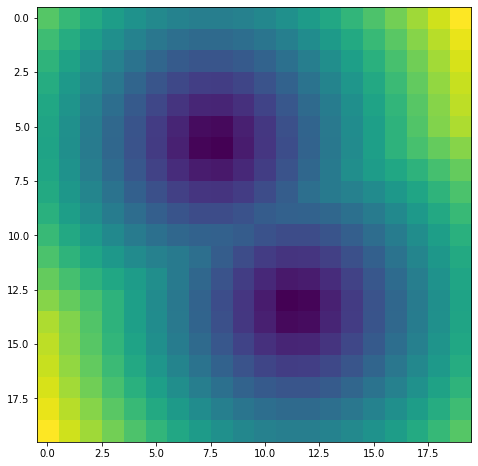


Case 2: data at `[0.4, 0.3], [0.6, 0.7], [0.3, 0.8], [0.5, 0.2]`, resolution 256 pixels.

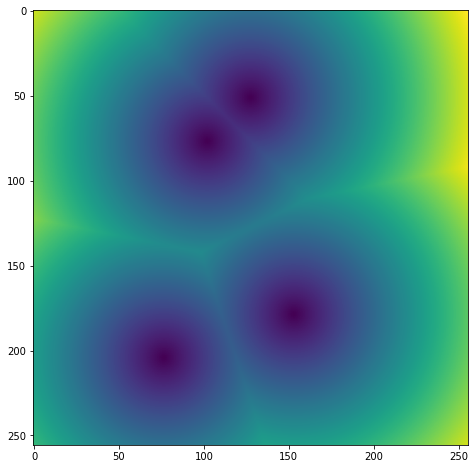


In [4]:
import torch

def min_dist(points, res):
    """Calculates a 2D tensor with the minimum distance from each pixel to data.

    Inputs:
      * points: a python list of 2D coordinates, normalized in the range [0,1]
      * res: the resolution of the output tensor.
    Returns:
      A res x res square tensor with floating point values corresponding to the
      euclidean distance to the closest point in points.
    """
    # Create a grid of pixel coordinates
    grid_x, grid_y = torch.meshgrid(torch.linspace(0, 1, res), torch.linspace(0, 1, res), indexing='ij')
    grid = torch.stack([grid_x, grid_y], dim=-1)  # Shape: [res, res, 2]

    # Convert points to a tensor
    points = torch.tensor(points).to(grid)

    # Calculate distances from all pixels to all points
    distances = torch.cdist(grid.view(-1, 2), points)  # Shape: [res*res, len(points)]

    # Find the minimum distance for each pixel
    min_distances = distances.min(dim=1).values  # Shape: [res*res]

    # Reshape to 2D tensor
    min_distances = min_distances.view(res, res)

    return min_distances


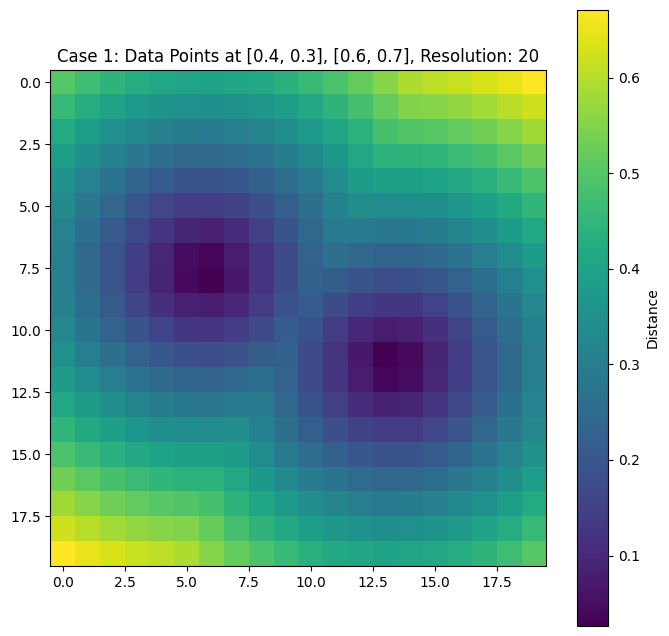

In [5]:
import matplotlib.pyplot as plt

# Case 1
distance_to_data = min_dist([[0.4, 0.3], [0.6, 0.7]], 20)
plt.figure(figsize=(8, 8))
plt.title("Case 1: Data Points at [0.4, 0.3], [0.6, 0.7], Resolution: 20")
plt.imshow(distance_to_data, cmap='viridis')
plt.colorbar(label='Distance')
plt.show()


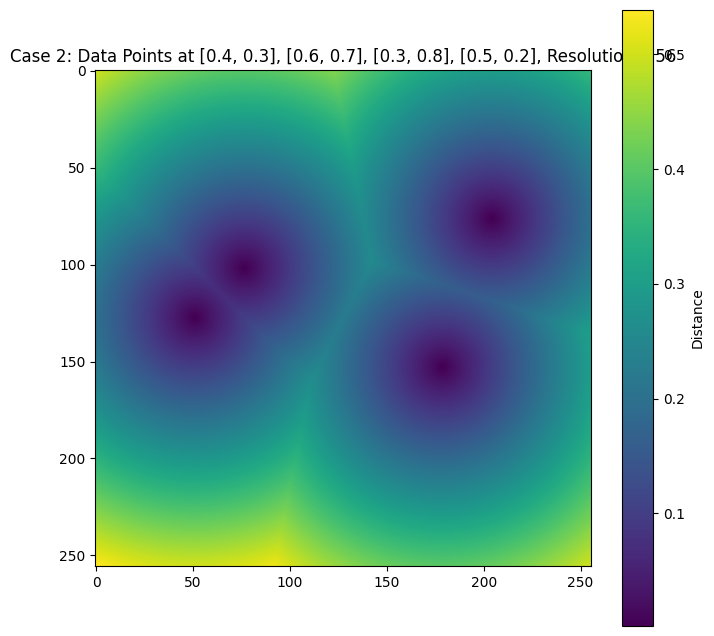

In [6]:
# Case 2
distance_to_data = min_dist([[0.4, 0.3], [0.6, 0.7], [0.3, 0.8], [0.5, 0.2]], 256)
plt.figure(figsize=(8, 8))
plt.title("Case 2: Data Points at [0.4, 0.3], [0.6, 0.7], [0.3, 0.8], [0.5, 0.2], Resolution: 256")
plt.imshow(distance_to_data, cmap='viridis')
plt.colorbar(label='Distance')
plt.show()


### Batched version

As a next step, improve the `min_dist` function to support batches.
The `points` array is now expected to be a tensor with shape [batch_size, num_points, 3], generated by `create_points`.
`min_dist` should return a batch of maps with shape [batch_size, res, res].
Again, make sure to implement `min_dist` using **no for-loops**.
Demonstrate your function output with `batch_size=3` and `num_points=4`.

In [7]:
def create_points(batch_size, num_points):
  coords = np.random.rand(batch_size, num_points, 2)
  values = np.random.randint(0, 10, batch_size*num_points).reshape(batch_size, num_points)
  values = np.expand_dims(values, 2)
  points = np.concatenate((coords, values), axis=2)
  return points

In [8]:
def min_dist_batched(points, res):
    """Calculates a 3D tensor with the minimum distance from each pixel to data.

    Inputs:
      * points: a numpy array of 2D coordinates and point values, normalized in the range [0,1].
                The expected shape is [B, P, 3].
      * res: the resolution of the output tensor.
    Returns:
      A [B, res, res] tensor with floating point values corresponding to the
      euclidean distance to the closest point in points.
    """
    # Convert points to PyTorch tensor
    points = torch.tensor(points)

    # Create grid for distance computation
    grid_x, grid_y = torch.meshgrid(torch.linspace(0, 1, res), torch.linspace(0, 1, res), indexing='ij')
    grid = torch.stack([grid_x, grid_y], dim=-1).unsqueeze(0)  # Shape: [1, res, res, 2]

    # Broadcast grid to match batch size
    B = points.shape[0]
    grid = grid.repeat(B, 1, 1, 1)  # Shape: [B, res, res, 2]

    # Extract coordinates (ignore values in points[:, :, 2])
    coords = points[:, :, :2]

    # Compute distances
    coords = coords.unsqueeze(1).unsqueeze(2)  # Shape: [B, 1, 1, P, 2]
    grid = grid.unsqueeze(3)  # Shape: [B, res, res, 1, 2]
    distances = torch.norm(grid - coords, dim=-1)  # Shape: [B, res, res, P]

    # Take the minimum distance
    min_distances = distances.min(dim=-1).values  # Shape: [B, res, res]

    return min_distances


In [9]:
def create_points(batch_size, num_points):
    coords = np.random.rand(batch_size, num_points, 2)  # Random [x, y] coordinates
    values = np.random.randint(0, 10, (batch_size, num_points, 1))  # Random point values
    points = np.concatenate((coords, values), axis=2)  # Combine coordinates and values
    return points


In [10]:
# Batch size and number of points per batch
batch_size = 3
num_points = 4

# Generate random points
points = create_points(batch_size, num_points)

# Test the batched function
res = 25  # Resolution of 25x25
distances = min_dist_batched(points, res)

# Verify the shape of the output
print("Output Shape:", distances.shape)  # Expected: [3, 25, 25]


Output Shape: torch.Size([3, 25, 25])


   Input :
  * points: a numpy array of 2D coordinates and point values, normalized to
    be in the range [0,1]. The expected shape is [B, P, 3].
  * res: the resolution of the output tensor.  
   
Returns:  
  * A (res x res) square tensor with floating point values corresponding to the
    euclidean distance to the closest point in points. The return tensor
    shape is [B, res, res].  

While I used the shape [3, P, 3] and res as input and obtained the shape [3, 25, 25] as output which veifies the correctness of the function.


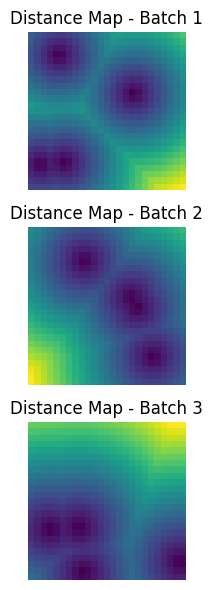

In [11]:
fig, axs = plt.subplots(batch_size, 1, figsize=(6, 6))
for i in range(batch_size):
    axs[i].imshow(distances[i], cmap='viridis')
    axs[i].set_title(f'Distance Map - Batch {i+1}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()